# Estudo de caso 1.1: Decifrando o genoma através da PCA e do K-Médias

Configuração do notebook:

In [ ]:
import requests
import numpy as np
import itertools
import pandas as pd
import re
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


# Download de dados

Conforme descrito no roteiro do Estudo de caso 1.1, tanto os dados do sequenciamento genômico da *Caulobacter Crescentus* quanto as funções do Matlab utilizadas pelos autores, podem ser baixados pelo [link](http://www.ihes.fr/~zinovyev/pcadg/).

Através da biblioteca `requests` podemos acessar esse sequenciamento e transformá-lo em uma `string` de Python:

In [ ]:
url = 'http://www.ihes.fr/~zinovyev/pcadg/ccrescentus.fa'
data = ''.join(requests.get(url, verify=False).text.split('\r\n')[1:])
print('Comprimento do sequenciamento do genoma da Caulobacter Crescentus: {}'.format(len(data)))
print('Primeiras 25 letras do sequenciamento: {}'.format(data[:25]))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ihes.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Comprimento do sequenciamento do genoma da Caulobacter Crescentus: 305400
Primeiras 25 letras do sequenciamento: gccgatagcctatgatccccggcag


# Geração de atributos

O artigo no qual o Estudo de caso 1.1 se baseia propõe a função `CalcFreq`do Matlab que gera atributos para cada fragmento de 300 letras do genoma. Um dos parâmetros dessa função é o comprimento M (chamado ''len'' na função), de subpalavras nas quais cada fragmento se divide (subpalavras de 1,2,3 ou 4 letras de comprimento). A função a seguir realiza as mesmas operações:

In [ ]:
def CalcFreq(_str,_len,wid):
    '''
    Inputs:
        _str: o sequenciamento completo
        _len: o comprimento das subpalavras (de 1 a 4 letras)
        wid:  o comprimento dos fragmentos (neste estudo são
              usados fragmentos de 300 letras)
    Output:
        xx: matriz de atributos
    '''
    #Dividindo o sequenciamento em fragmentos
    fragmentos = [_str[i:i+wid] for i in range(0, len(_str), wid)]

    #Gerando possíveis combinações de letras (atributos)
    letras = ['a','c','g','t']
    atributos = [''.join(i) for i in list(itertools.product(letras,repeat=_len))]

    #Calculando a frequência de cada atributo
    xx = np.zeros((len(fragmentos),len(atributos)))
    for i,frag in enumerate(fragmentos):
        frag = [frag[i:i+_len] for i in range(0, len(frag), _len)]
        for j,atr in enumerate(atributos):
            xx[i,j] = frag.count(atr)

    return xx

In [ ]:
xx1 = CalcFreq(data,1,300)
xx2 = CalcFreq(data,2,300)
xx3 = CalcFreq(data,3,300)
xx4 = CalcFreq(data,4,300)

In [ ]:
xx3

array([[0., 3., 1., ..., 0., 1., 1.],
       [1., 3., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 2., ..., 2., 2., 2.],
       [2., 2., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.]])

# PCA (Análise de componentes principais)

Uma vez que obtemos as tabelas com os atributos em função do comprimento das palavras, podemos reduzir a dimensionalidade de nossa informação, usando a Análise de Componentes Principais (PCA). As funções a seguir calculam os dois componentes principais através da biblioteca `sci-kit learn`, e mostram gráficos dos resultados:

In [ ]:
def PCAFreq(xx,_len):
    #Padronização dos diferentes atributos
    std_xx = StandardScaler().fit_transform(xx)
    #Redução para duas dimensões através da PCA
    pca = PCA(n_components=2)
    comp_principales = pca.fit_transform(std_xx)
    plot_PCA(comp_principales,_len)
    return comp_principales

def plot_PCA(comp_principales,_len):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x=comp_principales[:,0],y=comp_principales[:,1],
               marker='.',s=3,color='k',
              )
    ax.annotate('M = {}'.format(_len),xy=[0.1,0.8],xytext = (0.1,0.8),
                xycoords = 'axes fraction',fontsize=14)
    plt.show()


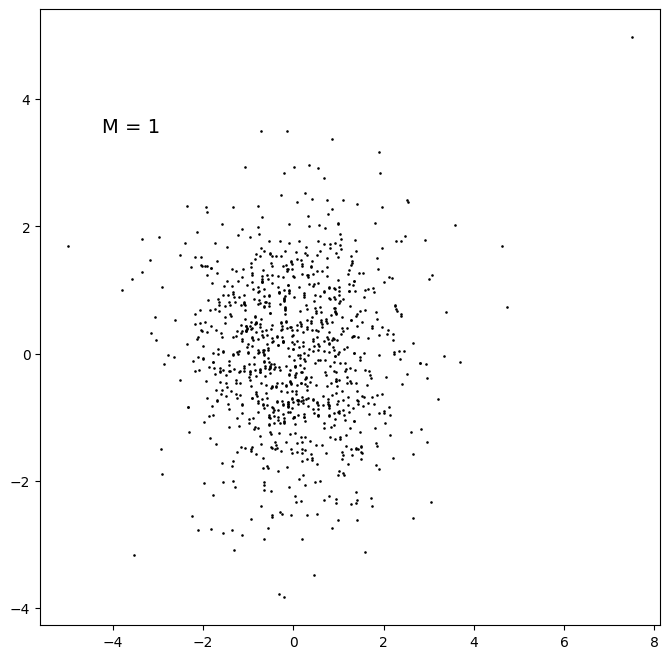

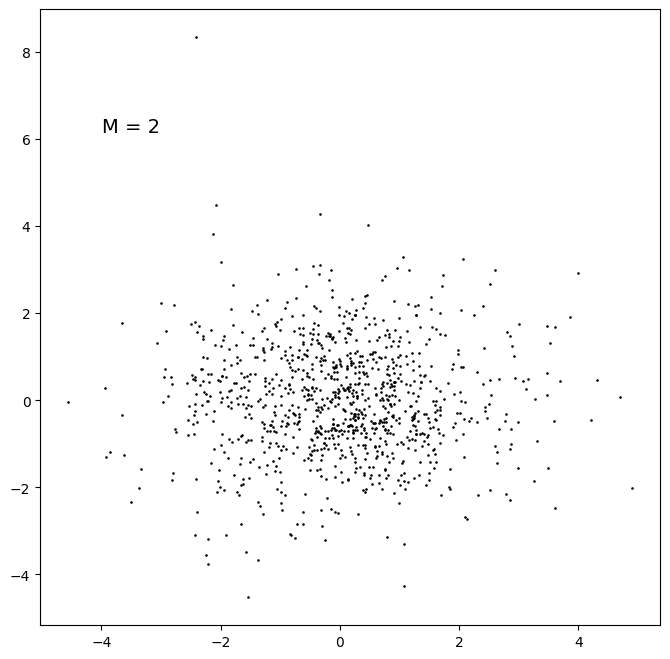

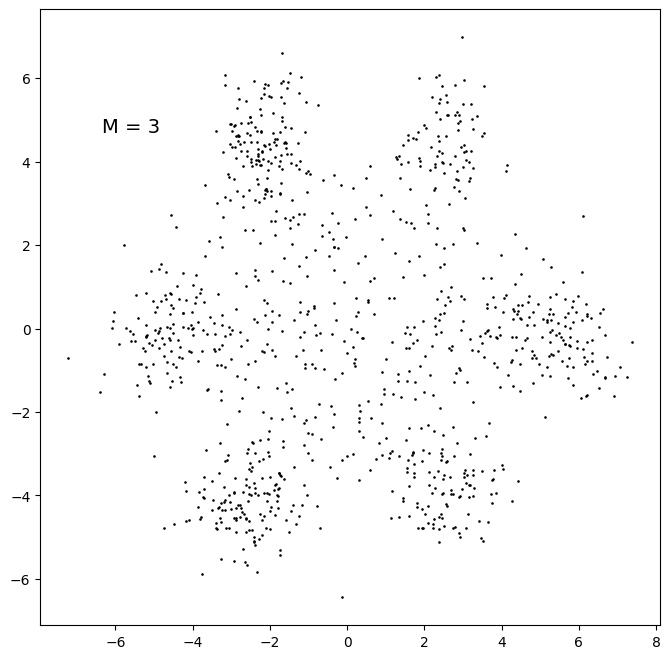

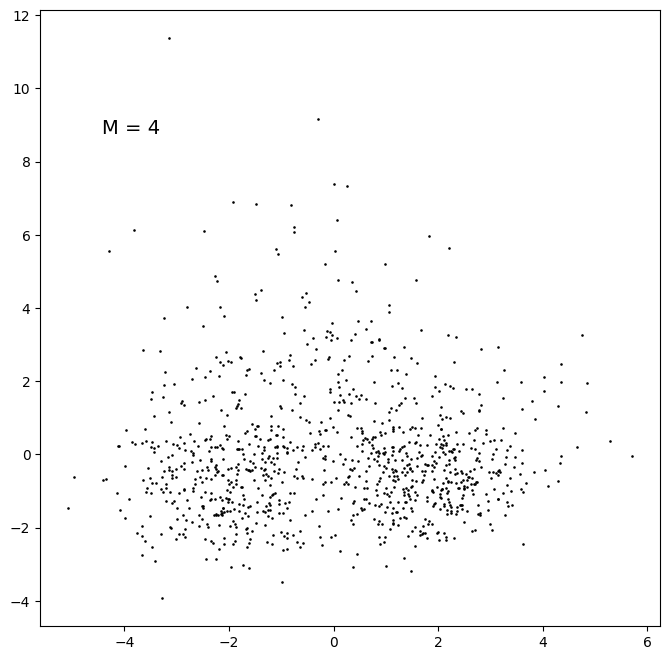

In [ ]:
xx1_PCA = PCAFreq(xx1,1)
xx2_PCA = PCAFreq(xx2,2)
xx3_PCA = PCAFreq(xx3,3)
xx4_PCA = PCAFreq(xx4,4)

# K-Médias (_K-Means_)

Por último, podemos aplicar o K-Médias à tabela gerada com palavras de 3 letras. Tenha atenção ao fato de que o K-Médias se aplica aos __64 atributos__ (não aos dois componentes principais obtidos através da PCA). Após isso, os resultados podem ser visualizados através da PCA ou diretamente sobre o sequenciamento genético.

In [ ]:
def ClustFreq(xx,k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(xx)
    clusters = kmeans.labels_
    return clusters

def plot_PCA_colors(xx_PCA,clusters):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    black_cluster = (clusters == 1)
    ax.scatter(x=xx_PCA[black_cluster][:,0],y=xx_PCA[black_cluster][:,1],color='k',
               marker='o',s=10)
    ax.scatter(x=xx_PCA[~black_cluster][:,0],y=xx_PCA[~black_cluster][:,1],
               c=clusters[~black_cluster],cmap='Paired_r',marker='o',s=10)
    plt.show()

def plot_letter_with_colors(data,clusters):
    fragmentos = [data[i:i+300] for i in range(0, len(data), 300)]
    color_map = {0:'grey',2:'red',3:'green',4:'yellow',5:'blue',6:'magenta'}
    for i,frag in enumerate(fragmentos):
        if clusters[i] == 1:
            print(frag)
        else:
            print(colored(frag, color=color_map[clusters[i]]))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


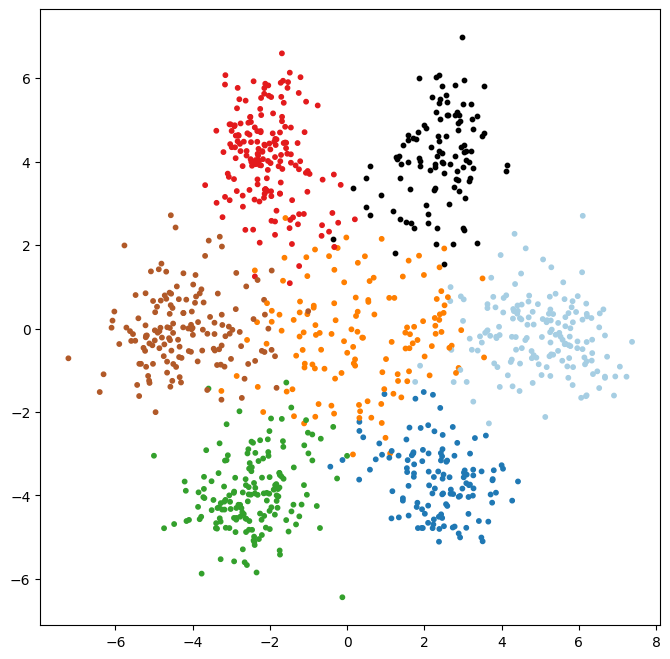

In [ ]:
clusters = ClustFreq(xx3,7)
plot_PCA_colors(xx3_PCA,clusters)

In [ ]:
plot_letter_with_colors(data[:30000],clusters[:100])

gccgatagcctatgatccccggcaggcccggggcttggagccgtctggtttggatggaaccctccaaaccagatcaagaggctcctagaacgccgcccgcagggtcacgccccaggtgcgcgggtcgcccggctggccggcgatcaggccggtgttgctgggacccacggccagttgctcgaaatagttctcgtcgaaggcgttgcggacccaggcatagaggttcagcccctcaggcgtgcggaagccggcccggaagttagcgatcgtgtagccgtcaacccaggtgtagatcgaggg
cgaagggttggacgagaacttgctgcggtagctgccgtcatagccgacatagaactcgcccgtcttgcccaggaagtcgcccggaacattggcctcggcccccagggccacgctccacttcgaaacgcccggcagccgctgacccgagacgtcgcagttggcggggctgagcgcgccggccacgccggccgcgcgcggaacctgggttccggtcgccaccgtgccgcccgacagttccggcgggcagggcgcgtcgacaaagcgcacatacttggcgtcggtataggcggcgttcagata
ggtcgagaagcgggcgttcgggcgataggccgagtccagctccacgccttgggtgcgcaccttgccggcgttggccagatagccgcgcagcacgcccagctggccgttgctcaccgtggcctggtagttcttgatgtcgctgcggaacaccgcaaggttggccgtcagggtgcggtccagccactgggtcttcaggccgccctcgaagtgattgatgtcctcgggcttgatcgcgcctgcggcctcgatcggcttgcccgccgcatcggtcggcaggccgttctggttgatgccgccggt
cttgaagctcttggcgtaggtggcgtaggccaggacgtcacggtccagctggtagcttgccgacaggtcgtaggtgaagttccagtcgtcgaagctg

# Tarefas extras:

A seguir, podem ser desenvolvidas as diferentes tarefas extras propostas no roteiro do estudo de caso...